USE VENV_1 AS A KERNEL

This notebook is exploits the cleaned and agregated dataset built in notebook P7_EDA to design a model predicting credit default while minimizing the rate of false negatives.
A SHAP explainer is built and fitted on the final model to be used for prediction interpration in the final streamlit dashboard.

Bothe the fitted explainer and the fitted final model are saved locally to be used in the streamlit dashboard

## importing libraries and custom functions

In [84]:
seed = 42

import numpy as np
import pandas as pd
import os
import re
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()
plt.rc('figure', figsize=(10, 6))

import pickle
import IPython.display

In [85]:
"""display options"""

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)
# pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
# pd.reset_option("max_colwidth")

In [86]:
"""Importing functions and style params"""
os.chdir('C:/Users/VP/Google Drive/Education/OC/working_directory/personal_modules')
%run -i useful_functions.py


# plot params
- set_style_pers

# EDA functions
 ## multiple dfs exploration
- dfs_insight
 ## univariate analysis
- plot_cont_kde
- plot_cat_countplot
# Clustering functions
- radar_ploting_clustering



<Figure size 720x432 with 0 Axes>

# Importing datasets after EDA

these datasets have been cleaned from outliers for DAYS_BIRTH, cat variables have been onehotencoded or labelencoded (card <= 2) and variables correlated at more than 0.8 were removed

In [87]:
with open("D:/Dowloads_D/Data_OC/P7/uncorr_data.txt", 'rb') as fic:
    mon_depickler = pickle.Unpickler(fic)
    loaded = mon_depickler.load()

train, test = loaded

In [88]:
dfs_dict= dict()
dfs_dict["train"] = train
dfs_dict["test"] = test

In [89]:
test.shape

(48744, 315)

# Particular case, imputation of Days_Employed

During the EDA, we spotted 55474 clients with an aberrant number of days_employed, we replaced it by NaN and flagged them with a column DAYS_EMPLOYED_ANOM.
We are now imputing them with the median of the following group: NAME_EDUCATION_TYPE>OCCUPATION_TYPE>AGE_GROUP (last one to be created below)

In [90]:
# to deep dive in EDA: there are three DAYS_EMPLOYED that are NaN but that are flagged as False, we correct it below:
# train.loc[(train['DAYS_EMPLOYED'].isna() == True) & (train['DAYS_EMPLOYED_ANOM'] == False), 'DAYS_EMPLOYED_ANOM'] = True
# train.loc[(train['DAYS_EMPLOYED'].isna() == True), 'DAYS_EMPLOYED_ANOM'] == True
# check done in EDA; looks ok, probably a punctual mistake

In [91]:
# we need categorical variables not encoded to compute this median
os.chdir('D:/Dowloads_D/Data_OC/P7' )
app_test_impute = pd.read_csv('application_test.csv', usecols=['SK_ID_CURR', 'NAME_EDUCATION_TYPE','DAYS_BIRTH', 'DAYS_EMPLOYED'])
app_train_impute = pd.read_csv('application_train.csv', usecols=['SK_ID_CURR', 'NAME_EDUCATION_TYPE','DAYS_BIRTH', 'DAYS_EMPLOYED'])

In [92]:
# we are going to use the age group of the client for the imputation as well
#            70y     60      45      21   
age_bins = [-25550, -21900, -16425, -7665, 0]
bins_labels = ['60-70', '45-60', '21-45', '0-21']
app_train_impute['AGE_GROUP'] = pd.cut(app_train_impute['DAYS_BIRTH'], age_bins, labels=bins_labels)
app_test_impute['AGE_GROUP'] = pd.cut(app_test_impute['DAYS_BIRTH'], age_bins, labels=bins_labels)

In [93]:
# we build our table of median per group using the train data (data leakage)
days_employed_medians = app_train_impute[['NAME_EDUCATION_TYPE', 'AGE_GROUP', 'DAYS_EMPLOYED']].groupby(['NAME_EDUCATION_TYPE', 'AGE_GROUP']).median().reset_index()
days_employed_medians.dropna(how='any', inplace=True)
days_employed_medians

,NAME_EDUCATION_TYPE,AGE_GROUP,DAYS_EMPLOYED
0,Academic degree,60-70,365243.0
1,Academic degree,45-60,-1552.0
2,Academic degree,21-45,-1846.0
4,Higher education,60-70,365243.0
5,Higher education,45-60,-1762.0
6,Higher education,21-45,-1435.0
8,Incomplete higher,60-70,365243.0
9,Incomplete higher,45-60,-1588.0
10,Incomplete higher,21-45,-1109.0
12,Lower secondary,60-70,365243.0


In [94]:
# we add non encoded grouping features to the train and test datasets to use them in the GroupBy
train['NAME_EDUCATION_TYPE'] = app_train_impute['NAME_EDUCATION_TYPE']
train['AGE_GROUP'] = app_train_impute['AGE_GROUP']

test['NAME_EDUCATION_TYPE'] = app_test_impute['NAME_EDUCATION_TYPE']
test['AGE_GROUP'] = app_test_impute['AGE_GROUP']

In [95]:
# alternative with custom heavy function that has the advatantage of preveting data leakage without creating a transformer 
mask_train = (train['DAYS_EMPLOYED_ANOM'] == True)
mask_test = (test['DAYS_EMPLOYED_ANOM'] == True)

def get_median(NAME_EDUCATION_TYPE, AGE_GROUP, days_employed_medians):
    
    days_employed_medians = days_employed_medians.loc[(days_employed_medians['NAME_EDUCATION_TYPE'] == NAME_EDUCATION_TYPE) 
                                                      # & (days_employed_medians['OCCUPATION_TYPE'] == OCCUPATION_TYPE) 
                                                      & (days_employed_medians['AGE_GROUP'] == AGE_GROUP),:]
    
    # print(days_employed_medians['DAYS_EMPLOYED'])
    return int(days_employed_medians['DAYS_EMPLOYED'])

In [96]:
train.loc[mask_train,'DAYS_EMPLOYED'] = train.loc[mask_train,:].apply(lambda x: get_median(x['NAME_EDUCATION_TYPE'], x['AGE_GROUP'], days_employed_medians), axis=1)
test.loc[mask_test,'DAYS_EMPLOYED'] = test.loc[mask_test,:].apply(lambda x: get_median(x['NAME_EDUCATION_TYPE'], x['AGE_GROUP'], days_employed_medians), axis=1)

In [97]:
# imputation using pandas (faster)
# fill_median = lambda g: g.fillna(g.median())
# train.loc[train['DAYS_EMPLOYED_ANOM'] == True,'DAYS_EMPLOYED'] = train.groupby(['NAME_EDUCATION_TYPE', 'AGE_GROUP'])['DAYS_EMPLOYED'].apply(fill_median)

In [98]:
# imputation using pandas (faster) + use of general median in case of median equal to NaN for the group
"""
def median(s):
    m = s.median()
    if np.isnan(m):
        m = train['DAYS_EMPLOYED'].median()
    return m
train['DAYS_EMPLOYED'] =  (train.groupby(['NAME_EDUCATION_TYPE', 'AGE_GROUP'],
                                         dropna=False
                                        )
                                ['DAYS_EMPLOYED'].apply(lambda x: x.fillna(median(x)))
                          )
"""

"\ndef median(s):\n    m = s.median()\n    if np.isnan(m):\n        m = train['DAYS_EMPLOYED'].median()\n    return m\ntrain['DAYS_EMPLOYED'] =  (train.groupby(['NAME_EDUCATION_TYPE', 'AGE_GROUP'],\n                                         dropna=False\n                                        )\n                                ['DAYS_EMPLOYED'].apply(lambda x: x.fillna(median(x)))\n                          )\n"

In [99]:
# droping cat columns used for imputation
train.drop(['NAME_EDUCATION_TYPE', 'AGE_GROUP'], axis=1, inplace=True)
# droping another useless column
# train.drop(['1'], axis=1, inplace=True)

test.drop(['NAME_EDUCATION_TYPE', 'AGE_GROUP'], axis=1, inplace=True)
# droping another useless column
# test.drop(['1'], axis=1, inplace=True)

# Preprocessing pipeline

# sampling dataset for cross validation

In [100]:
from sklearn.model_selection import train_test_split

In [101]:
# sampling the train dataset to make the CV faster, stratifying as per TARGET
train_sample, val_sample = train_test_split(train, test_size=0.90, stratify=train['TARGET'], random_state=seed)

In [102]:
target_count = train_sample['TARGET'].value_counts()
target_count

0    28269
1     2482
Name: TARGET, dtype: int64

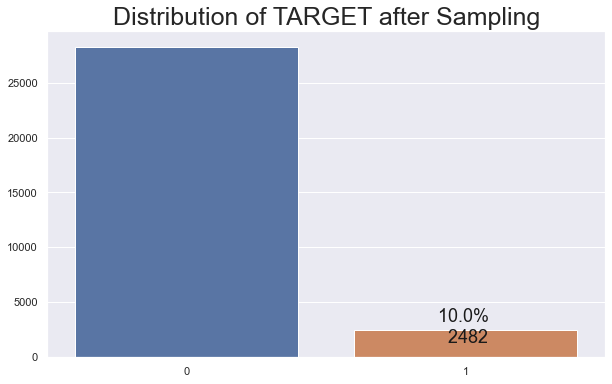

In [103]:
sns.barplot(x=target_count.index, y=target_count.values)

for p in plt.gca().patches:
    plt.gca().annotate("{:.1%} \n {}".format(round(p.get_height() / sum(target_count.values), 1)
                                             , round(p.get_height()))                             # % and count
                        , (p.get_x()+0.4, p.get_height()+2000)                                    # position
                        , ha='center', va='top', color='k', size=18)                              # kwargs
    
plt.title('Distribution of TARGET after Sampling', fontsize=25);

## imputation transform

We are building different imputers to find the best one. Note that categorical variables are now numeric thanks to encoding, so no need to applied a separate treatment

In [104]:
from sklearn.impute import SimpleImputer

In [105]:
median_imputer = SimpleImputer(strategy='median')
mean_imputer = SimpleImputer(strategy='mean')
zero_imputer = SimpleImputer(strategy='constant')

### Custom imputer

We are going to create a custom transformer that will apply two distinct treatments, either 0 for for selected variables or the the median by  for all the other variables

In [106]:
train[[col for col in train.columns if 'bureau' not in col]].isna().sum().sort_values(ascending=False).head(30)

COMMONAREA_AVG                              214865
NONLIVINGAPARTMENTS_AVG                     213514
FLOORSMIN_AVG                               208642
YEARS_BUILD_AVG                             204488
OWN_CAR_AGE                                 202929
LANDAREA_AVG                                182590
BASEMENTAREA_AVG                            179943
NONLIVINGAREA_AVG                           169682
APARTMENTS_AVG                              156061
ENTRANCES_AVG                               154828
FLOORSMAX_AVG                               153020
YEARS_BEGINEXPLUATATION_AVG                 150007
AMT_REQ_CREDIT_BUREAU_HOUR                   41519
AMT_REQ_CREDIT_BUREAU_YEAR                   41519
AMT_REQ_CREDIT_BUREAU_DAY                    41519
AMT_REQ_CREDIT_BUREAU_WEEK                   41519
AMT_REQ_CREDIT_BUREAU_MON                    41519
AMT_REQ_CREDIT_BUREAU_QRT                    41519
DEF_30_CNT_SOCIAL_CIRCLE                      1021
OBS_30_CNT_SOCIAL_CIRCLE       

EXT_SOURCE_2_x has 0.2% of NaN, so we can impute it with median despite its correlation to the target without running the risk of biasing the dataset

In [107]:
# variables where NaN will be replaced by 0
zero_imputed_cols = [
       *list(train[[col for col in train.columns if 'bureau' in col]].isna().mean().sort_values(ascending=False).index) # all variables to the bureau datasets, NaN are all the clients of app train that had no history in the bueau datasets, so 0 is a relevant choice
        , 'COMMONAREA_AVG' # if the person is not living in a common area, 0 would be logical
        , 'YEARS_BUILD_AVG'
        , 'OWN_CAR_AGE'   # NaN probably means client does not own a car
        , 'YEARS_BEGINEXPLUATATION_AVG'
        , 'AMT_REQ_CREDIT_BUREAU_HOUR'  # number of enquiries made about a client to credit bureau, NaN means probably no inquiries were made
        , 'AMT_REQ_CREDIT_BUREAU_DAY'
        , 'AMT_REQ_CREDIT_BUREAU_WEEK'
        , 'AMT_REQ_CREDIT_BUREAU_MON'
        , 'AMT_REQ_CREDIT_BUREAU_QRT'
        , 'AMT_REQ_CREDIT_BUREAU_YEAR'
        , 'DEF_30_CNT_SOCIAL_CIRCLE'   # NaN probably means no observations
        , 'OBS_30_CNT_SOCIAL_CIRCLE'
    
]

# variables where NaN will be replaced by median
non_zero_imputed_cols = [col for col in train.columns if col not in zero_imputed_cols]

In [108]:
from sklearn.compose import ColumnTransformer
cust_imputer = ColumnTransformer([
      ("zero_imputer", SimpleImputer(strategy='constant'), zero_imputed_cols)
    , ("median", SimpleImputer(strategy='median'), non_zero_imputed_cols)
], remainder='passthrough')

In [109]:
# test to check that custom imputer works
# train_array = cust_imputer.fit_transform(train)

In [110]:
# train_array = pd.DataFrame(train_array, index = train.index, columns=train.columns)

In [111]:
# train_array[[col for col in train.columns if 'bureau' not in col]].isna().sum().sort_values(ascending=False).head(30)
# train_array.isna().sum().sort_index().head(30)
# train[non_zero_imputed_cols].isna().sum().sort_values(ascending=False).head(100)
# train['ENTRANCES_AVG'].median()

## feature scaling transform

In [112]:
from sklearn.preprocessing import MinMaxScaler, RobustScaler

MinMaxScaler = MinMaxScaler()
RobustScaler = RobustScaler()

## RUS and SMOTE

In [113]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as im_pipeline

# parameters to adapt
over = SMOTE(sampling_strategy=0.8, random_state=seed) # means that we want the minority class population to be oversampled up to 60% of the majority class pop
under = RandomUnderSampler(sampling_strategy='majority', random_state=seed) # will under sample the majority class down to be equal to the minority classs pop
over_under = im_pipeline(steps=[
      ('over', over)
    , ('under', under)
])

## Feature selection

In [114]:
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectKBest

rfe = RFE(estimator=DecisionTreeClassifier(random_state=seed), n_features_to_select=50)
SKB = SelectKBest(k=50)

# GridSearchCV per model

We are going to to a grid search for steps and hyperparamaters for to models successively: RFClassifier and LGBM

In [115]:
from sklearn.model_selection import StratifiedKFold

## lists of models

In [116]:
models_cv = []
mean_train_scores = []
mean_test_scores = []

## SKFold and spliting X and y

In [117]:
# stratified kfold used for the two CVs
Skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

In [118]:
# splitting features and Target 
X, y = train_sample.iloc[:,2:-1], train_sample.iloc[:,-1]

## RFClassifier

In [119]:
from sklearn.ensemble import RandomForestClassifier
RFC = RandomForestClassifier(random_state=seed)

### building imbl pipeline and grid

In [120]:
pipe_rfc = im_pipeline(steps=[
      ('imputer', SimpleImputer())
    , ('scaler', MinMaxScaler())
    , ('weight_strat', SMOTE())
    , ('feat_selec', SelectKBest(k=50))
    , ('RFC', RandomForestClassifier())    
]
    ,memory="D:/Dowloads_D/Data_OC/P7", verbose=True)

In [121]:
imputers=[
    # median_imputer 
     mean_imputer # best
    # , zero_imputer # retunrs NaN, 0s cause a division to raise an error
    # , cust_imputer # retunrs NaN
]
# scalers
scalers=[
     #MinMaxScaler
     RobustScaler()    #best
]
# over/undersampling
weight_strat=[
    # over
     under
    # , over_under #returns NaN
]
# Feature_selectors
SKB #best

# params grid

param_grid_rfc = {  'imputer': imputers
        , 'scaler': scalers
        , 'weight_strat': weight_strat
        , 'feat_selec': [SKB] 
        , 'RFC': [RFC]
        , 'RFC__max_depth': [10]
        , 'RFC__n_estimators': [50]
       }

In [122]:
from sklearn.model_selection import GridSearchCV

grid_rfc = GridSearchCV(pipe_rfc, param_grid_rfc, cv=Skfold, scoring='roc_auc', verbose=2, n_jobs=-1, return_train_score=True)

In [123]:
%%timeit
grid_rfc.fit(X, y)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[Pipeline] ............... (step 5 of 5) Processing RFC, total=   0.6s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[Pipeline] ............... (step 5 of 5) Processing RFC, total=   0.5s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[Pipeline] ............... (step 5 of 5) Processing RFC, total=   0.5s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[Pipeline] ............... (step 5 of 5) Processing RFC, total=   0.5s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[Pipeline] ............... (step 5 of 5) Processing RFC, total=   0.6s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[Pipeline] ............... (step 5 of 5) Processing RFC, total=   0.5s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[Pipeline] ............... (step 5 of 5) Processing RFC, total=   0.6s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[Pipeline] ............... (ste

In [124]:
grid_rfc.best_params_

{'RFC': RandomForestClassifier(max_depth=10, n_estimators=50, random_state=42),
 'RFC__max_depth': 10,
 'RFC__n_estimators': 50,
 'feat_selec': SelectKBest(k=50),
 'imputer': SimpleImputer(),
 'scaler': RobustScaler(),
 'weight_strat': RandomUnderSampler(random_state=42, sampling_strategy='majority')}

In [125]:
grid_rfc_results = pd.DataFrame(grid_rfc.cv_results_)

In [126]:
grid_rfc_results.head(1)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_RFC,param_RFC__max_depth,param_RFC__n_estimators,param_feat_selec,param_imputer,param_scaler,param_weight_strat,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,1.555247,0.302201,0.407504,0.066585,"RandomForestClassifier(max_depth=10, n_estimators=50, random_state=42)",10,50,SelectKBest(k=50),SimpleImputer(),RobustScaler(),"RandomUnderSampler(random_state=42, sampling_strategy='majority')","{'RFC': RandomForestClassifier(max_depth=10, n_estimators=50, random_state=42), 'RFC__max_depth': 10, 'RFC__n_estimators': 50, 'feat_selec': SelectKBest(k=50), 'imputer': SimpleImputer(), 'scaler': RobustScaler(), 'weight_strat': RandomUnderSampler(random_state=42, sampling_strategy='majority')}",0.725277,0.71751,0.697758,0.710766,0.703702,0.711003,0.009745,1,0.878682,0.87676,0.885189,0.876448,0.879515,0.879319,0.003153


#### Imputers grid results

In [127]:
grid_rfc_results['param_imputer'] = grid_rfc_results['param_imputer'].astype('str')

In [128]:
grid_rfc_results[['param_imputer', 'mean_test_score', 'std_test_score']].groupby('param_imputer').agg({'mean_test_score':'mean', 'std_test_score':'mean'})

,mean_test_score,std_test_score
param_imputer,,
SimpleImputer(),0.711003,0.009745


Mean imputation (0.695) is slightly better than median (0.688) imputation. Why constant and custom imputation threw NaN ?

#### Scaler grid results

In [129]:
grid_rfc_results['param_scaler'] = grid_rfc_results['param_scaler'].astype('str')

In [130]:
grid_rfc_results[['param_scaler', 'mean_test_score', 'std_test_score']].groupby('param_scaler').agg({'mean_test_score':'mean', 'std_test_score':'mean'})

,mean_test_score,std_test_score
param_scaler,,
RobustScaler(),0.711003,0.009745


RobustScaler (0.694) is slightly better than MinMaxScaler (0.688987)

#### Weight strat grid results

In [131]:
grid_rfc_results['param_weight_strat'] = grid_rfc_results['param_weight_strat'].astype('str')

In [132]:
grid_rfc_results[['param_weight_strat', 'mean_test_score', 'std_test_score']].groupby('param_weight_strat').agg({'mean_test_score':'mean', 'std_test_score':'mean'})

,mean_test_score,std_test_score
param_weight_strat,,
"RandomUnderSampler(random_state=42, sampling_strategy='majority')",0.711003,0.009745


RUS is slitghly better (0.714754) VS SMOTE (0.710505). Why over_under returns NaN ?

#### Feature selector grid results

In [133]:
grid_rfc_results['param_feat_selec'] = grid_rfc_results['param_feat_selec'].astype('str')

In [134]:
grid_rfc_results[['param_feat_selec', 'mean_test_score', 'std_test_score']].groupby('param_feat_selec').agg({'mean_test_score':'mean', 'std_test_score':'mean'})

,mean_test_score,std_test_score
param_feat_selec,,
SelectKBest(k=50),0.711003,0.009745


En moyenne sur l'ensemble des 320 fits SelectKbest(k=50) (avg test AUC: 0.698) est meilleur est beaucoup plus rapide que RFE (avg test AUC: 0.684)

grille des fits
param_grid_rfc = {  'imputer': [SimpleImputer(strategy='median'), SimpleImputer(strategy='mean'), SimpleImputer(strategy='constant'), cust_imputer]
        , 'scaler': [MinMaxScaler(), RobustScaler()]
        , 'over': [over]
        #, 'under': [RandomUnderSampler(sampling_strategy=0.5)]
        , 'feat_selec': [rfe, SKB] 
        , 'RFC': [RFC]
        , 'RFC__max_depth': [None, 10, 20, 30]
        , 'RFC__n_estimators': [100,]
       }

In [135]:
models_cv.append('RFClassifier')
mean_test_scores.append(max(grid_rfc.cv_results_['mean_test_score']))
mean_train_scores.append(max(grid_rfc.cv_results_['mean_train_score']))

## LGBMC

In [136]:
from lightgbm import LGBMClassifier
LBMC = LGBMClassifier(objective='binary', random_state=seed)

### building imbl pipeline and grid

In [137]:
pipe_lgbm = im_pipeline(steps=[
      ('imputer', SimpleImputer())
    , ('scaler', MinMaxScaler())
    , ('weight_strat', SMOTE())
#    , ('under', RandomUnderSampler())
    , ('feat_selec', SelectKBest(k=50))
    , ('LBMC', LGBMClassifier())    
]
    ,memory="D:/Dowloads_D/Data_OC/P7", verbose=True)

In [138]:
imputers=[
     median_imputer # best
    #, mean_imputer 
    #, zero_imputer # retunrs NaN
    #, cust_imputer # retunrs NaN
]
# scalers
scalers=[
     #MinMaxScaler
     RobustScaler()    #best
]
# over/undersampling
weight_strat=[
    #  over
     under
    # , over_under # returns NaN
]
# Feature_selectors
SKB #best

# LGBM parameters
boosting_type = [
    #'gbdt'
     'dart' # best
    #, 'goss'
    #, 'rf'   
]
max_depth =[
    7
    #, 8
    #, 10
    #, 50
    #, 100
    #, None
]
n_estimators=[
  #  20
  #  , 30
     40
]
num_leaves=[
   # 5
     7
   # , 10
]
subsample=[
    1
   # , .8
]
colsample_bytree=[
    .8
]
reg_alpha=[
    # 0
    .1
]
reg_lambda=[
    0
    # , .1
]
min_split_gain=[
      0
    # , .01
]
# params grid

param_grid_lgbm = {
          'imputer': imputers
        , 'scaler': scalers
        , 'weight_strat': weight_strat
        #, 'under': [RandomUnderSampler(sampling_strategy=0.5)]
        , 'feat_selec': [SKB] 
        , 'LBMC': [LBMC]
        , 'LBMC__n_estimators':n_estimators
        , 'LBMC__num_leaves':num_leaves
        , 'LBMC__colsample_bytree':colsample_bytree
        , 'LBMC__subsample':subsample
        , 'LBMC__max_depth':max_depth
        , 'LBMC__reg_alpha':reg_alpha
        , 'LBMC__reg_lambda':reg_lambda
        , 'LBMC__min_split_gain':min_split_gain
       }

In [139]:
from sklearn.model_selection import GridSearchCV

grid_lgbm = GridSearchCV(pipe_lgbm, param_grid_lgbm, cv=Skfold, scoring='roc_auc', verbose=2, n_jobs=-1, return_train_score=True)

In [140]:
%timeit
grid_lgbm.fit(X, y)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[Pipeline] .............. (step 5 of 5) Processing LBMC, total=   0.1s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(memory='D:/Dowloads_D/Data_OC/P7',
                                steps=[('imputer', SimpleImputer()),
                                       ('scaler', MinMaxScaler()),
                                       ('weight_strat', SMOTE()),
                                       ('feat_selec', SelectKBest(k=50)),
                                       ('LBMC', LGBMClassifier())],
                                verbose=True),
             n_jobs=-1,
             param_grid={'LBMC': [LGBMClassifier(colsample_bytree=0....
                         'LBMC__n_estimators': [40], 'LBMC__num_leaves': [7],
                         'LBMC__reg_alpha': [0.1], 'LBMC__reg_lambda': [0],
                         'LBMC__subsample': [1],
                         'feat_selec': [SelectKBest(k=50)],
                         'imputer': [SimpleImputer(strategy='median')],
                         'scaler': 

In [141]:
max(grid_lgbm.cv_results_['mean_test_score'])

0.7234864597583286

In [142]:
grid_lgbm.best_params_

{'LBMC': LGBMClassifier(colsample_bytree=0.8, max_depth=7, min_split_gain=0,
                n_estimators=40, num_leaves=7, objective='binary',
                random_state=42, reg_alpha=0.1, reg_lambda=0, subsample=1),
 'LBMC__colsample_bytree': 0.8,
 'LBMC__max_depth': 7,
 'LBMC__min_split_gain': 0,
 'LBMC__n_estimators': 40,
 'LBMC__num_leaves': 7,
 'LBMC__reg_alpha': 0.1,
 'LBMC__reg_lambda': 0,
 'LBMC__subsample': 1,
 'feat_selec': SelectKBest(k=50),
 'imputer': SimpleImputer(strategy='median'),
 'scaler': RobustScaler(),
 'weight_strat': RandomUnderSampler(random_state=42, sampling_strategy='majority')}

### backup best params and scores

full param grid best params
{'LBMC': LGBMClassifier(colsample_bytree=0.8, max_depth=10, min_split_gain=0,
                n_estimators=50, num_leaves=10, objective='binary',
                random_state=42, reg_alpha=0, reg_lambda=0, subsample=1),
 'LBMC__colsample_bytree': 0.8,
 'LBMC__max_depth': 10,
 'LBMC__min_split_gain': 0,
 'LBMC__n_estimators': 50,
 'LBMC__num_leaves': 10,
 'LBMC__reg_alpha': 0,
 'LBMC__reg_lambda': 0,
 'LBMC__subsample': 1,
 'feat_selec': SelectKBest(k=50),
 'imputer': SimpleImputer(strategy='median'),
 'scaler': RobustScaler(),
 'weight_strat': SMOTE(random_state=42, sampling_strategy=0.4)}

best score = 0.715

second more specific grid
{'LBMC': LGBMClassifier(colsample_bytree=0.8, max_depth=7, min_split_gain=0,
                n_estimators=40, num_leaves=10, objective='binary',
                random_state=42, reg_alpha=0.1, reg_lambda=0, subsample=1),
 'LBMC__colsample_bytree': 0.8,
 'LBMC__max_depth': 7,
 'LBMC__min_split_gain': 0,
 'LBMC__n_estimators': 40,
 'LBMC__num_leaves': 10,
 'LBMC__reg_alpha': 0.1,
 'LBMC__reg_lambda': 0,
 'LBMC__subsample': 1,
 'feat_selec': SelectKBest(k=50),
 'imputer': SimpleImputer(strategy='median'),
 'scaler': RobustScaler(),
 'weight_strat': SMOTE(random_state=42, sampling_strategy=0.4)}
 
 best score:0.7146
 the score is not better
 
 third grid: increased the size of the training set by 8%
 {'LBMC': LGBMClassifier(colsample_bytree=0.8, max_depth=7, min_split_gain=0,
                n_estimators=40, num_leaves=10, objective='binary',
                random_state=42, reg_alpha=0.1, reg_lambda=0, subsample=1),
 'LBMC__colsample_bytree': 0.8,
 'LBMC__max_depth': 7,
 'LBMC__min_split_gain': 0,
 'LBMC__n_estimators': 40,
 'LBMC__num_leaves': 10,
 'LBMC__reg_alpha': 0.1,
 'LBMC__reg_lambda': 0,
 'LBMC__subsample': 1,
 'feat_selec': SelectKBest(k=50),
 'imputer': SimpleImputer(strategy='median'),
 'scaler': RobustScaler(),
 'weight_strat': SMOTE(random_state=42, sampling_strategy=0.4)}
 
 best score: 0.7118340056655664

In [143]:
df_grid_lgbm = pd.DataFrame(grid_lgbm.cv_results_)

In [144]:
df_grid_lgbm.head(1)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_LBMC,param_LBMC__colsample_bytree,param_LBMC__max_depth,param_LBMC__min_split_gain,param_LBMC__n_estimators,param_LBMC__num_leaves,param_LBMC__reg_alpha,param_LBMC__reg_lambda,param_LBMC__subsample,param_feat_selec,param_imputer,param_scaler,param_weight_strat,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,9.910033,3.73949,0.286035,0.04725,"LGBMClassifier(colsample_bytree=0.8, max_depth=7, min_split_gain=0,\n n_estimators=40, num_leaves=7, objective='binary',\n random_state=42, reg_alpha=0.1, reg_lambda=0, subsample=1)",0.8,7,0,40,7,0.1,0,1,SelectKBest(k=50),SimpleImputer(strategy='median'),RobustScaler(),"RandomUnderSampler(random_state=42, sampling_strategy='majority')","{'LBMC': LGBMClassifier(colsample_bytree=0.8, max_depth=7, min_split_gain=0, n_estimators=40, num_leaves=7, objective='binary', random_state=42, reg_alpha=0.1, reg_lambda=0, subsample=1), 'LBMC__colsample_bytree': 0.8, 'LBMC__max_depth': 7, 'LBMC__min_split_gain': 0, 'LBMC__n_estimators': 40, 'LBMC__num_leaves': 7, 'LBMC__reg_alpha': 0.1, 'LBMC__reg_lambda': 0, 'LBMC__subsample': 1, 'feat_selec': SelectKBest(k=50), 'imputer': SimpleImputer(strategy='median'), 'scaler': RobustScaler(), 'weight_strat': RandomUnderSampler(random_state=42, sampling_strategy='majority')}",0.738118,0.723287,0.720692,0.727866,0.707469,0.723486,0.009977,1,0.74775,0.75278,0.764042,0.753676,0.762122,0.756074,0.006098


#### Imputers grid results

In [145]:
df_grid_lgbm['param_imputer'] = df_grid_lgbm['param_imputer'].astype('str')

In [146]:
df_grid_lgbm[['param_imputer', 'mean_test_score', 'std_test_score']].groupby('param_imputer').agg({'mean_test_score':'mean', 'std_test_score':'mean'})

,mean_test_score,std_test_score
param_imputer,,
SimpleImputer(strategy='median'),0.723486,0.009977


median imputation (0.680) is slightly better than mean (0.679) imputation. Why constant and custom imputation threw NaN ?

#### Scaler grid results

In [147]:
df_grid_lgbm['param_scaler'] = df_grid_lgbm['param_scaler'].astype('str')

In [148]:
df_grid_lgbm[['param_scaler', 'mean_test_score', 'std_test_score']].groupby('param_scaler').agg({'mean_test_score':'mean', 'std_test_score':'mean'})

,mean_test_score,std_test_score
param_scaler,,
RobustScaler(),0.723486,0.009977


RobustScaler (0.681) is slightly better than MinMaxScaler (0.678315)

#### Weight strat grid results

In [149]:
df_grid_lgbm['param_weight_strat'] = df_grid_lgbm['param_weight_strat'].astype('str')

In [150]:
df_grid_lgbm[['param_weight_strat', 'mean_test_score', 'std_test_score']].groupby('param_weight_strat').agg({'mean_test_score':'mean', 'std_test_score':'mean'})

,mean_test_score,std_test_score
param_weight_strat,,
"RandomUnderSampler(random_state=42, sampling_strategy='majority')",0.723486,0.009977


In [151]:
df_grid_lgbm[df_grid_lgbm['param_weight_strat'].str.contains('Pipeline')]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_LBMC,param_LBMC__colsample_bytree,param_LBMC__max_depth,param_LBMC__min_split_gain,param_LBMC__n_estimators,param_LBMC__num_leaves,param_LBMC__reg_alpha,param_LBMC__reg_lambda,param_LBMC__subsample,param_feat_selec,param_imputer,param_scaler,param_weight_strat,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score


#### Feature selector grid results

In [152]:
df_grid_lgbm['param_feat_selec'] = df_grid_lgbm['param_feat_selec'].astype('str')

In [153]:
df_grid_lgbm[['param_feat_selec', 'mean_test_score', 'std_test_score']].groupby('param_feat_selec').agg({'mean_test_score':'mean', 'std_test_score':'mean'})

,mean_test_score,std_test_score
param_feat_selec,,
SelectKBest(k=50),0.723486,0.009977


En moyenne sur l'ensemble des 320 fits SelectKbest(k=50) (avg test AUC: 0.698) est meilleur est beaucoup plus rapide que RFE (avg test AUC: 0.684)

grille des fits
param_grid_rfc = {  'imputer': [SimpleImputer(strategy='median'), SimpleImputer(strategy='mean'), SimpleImputer(strategy='constant'), cust_imputer]
        , 'scaler': [MinMaxScaler(), RobustScaler()]
        , 'over': [over]
        #, 'under': [RandomUnderSampler(sampling_strategy=0.5)]
        , 'feat_selec': [rfe, SKB] 
        , 'RFC': [RFC]
        , 'RFC__max_depth': [None, 10, 20, 30]
        , 'RFC__n_estimators': [100,]
       }

In [154]:
models_cv.append('LGBMC')
mean_test_scores.append(max(df_grid_lgbm['mean_test_score']))
mean_train_scores.append(max(df_grid_lgbm['mean_train_score']))

# Selection of the best pipe

In [155]:
set_style_pers()

Text(0.5, 1.0, 'Comparison of mean train and test scores of RFC and LGBMC')

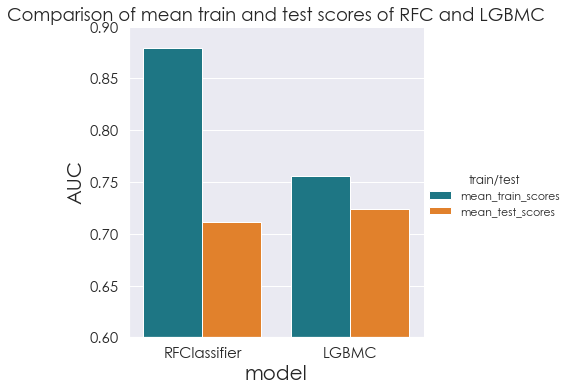

In [156]:
# in oder to plot the scores by model, we build a df and melt it to use train/test as an hue
df_models_scores = pd.DataFrame()
df_models_scores['model'] = models_cv
df_models_scores['mean_train_scores'] = mean_train_scores
df_models_scores['mean_test_scores'] = mean_test_scores
df_models_scores = pd.melt(df_models_scores, id_vars='model', var_name='train/test', value_name='AUC')
sns.catplot(data=df_models_scores, x='model', y='AUC', hue='train/test', kind='bar')
plt.gca().set_ylim([0.6, 0.9])
plt.gca().set_title('Comparison of mean train and test scores of RFC and LGBMC', fontsize=18)


In [157]:
# creating the best pipe with the optimised parameters and steps
best_pipe = im_pipeline(steps=[
      ('imputer', SimpleImputer(strategy='median'))
    , ('scaler', RobustScaler())
    , ('weight_strat', RandomUnderSampler(sampling_strategy='majority', random_state=seed))
    , ('feat_selec', SelectKBest(k=50))
    , ('LBMC', LGBMClassifier(colsample_bytree=0.8, max_depth=7, min_split_gain=0,
                n_estimators=40, num_leaves=10, objective='binary',
                random_state=seed, reg_alpha=0.1, reg_lambda=0, subsample=1))    
]
    ,memory="D:/Dowloads_D/Data_OC/P7", verbose=True)

## split Xval, yval

In [168]:
Xval, yval = val_sample.iloc[:,2:-1], val_sample.iloc[:,-1]

## lists for baseline comparison

In [169]:
# These lists will collect the different metrics values for baseline, not optimized best model, and optimized best model
# optimized means using a probability threshold that minimizes false negatives
models_bs_check = []
recalls_bs_check = []
accuracy_bs_check = []
auc_bs_check = []
fn_bs_check = []
cust_metrics_bs_check = []

# Definition of custom metric to minimize fn

In [170]:
def cust_metric(ytrue, yval_pred):
    """we sum up the tems of the confusion matrix, false positives and false nagatives a negatively correlated to the score.
    False negatives 10 times more than false positives.
    In production, it will be up to the client to decide how both false predictions should impact the metrics"""
    tp, fn, fp, tn = confusion_matrix(yval, yval_pred, labels=[1, 0]).ravel()
    score = (tp - 10*fn - fp + tn)/(tp + fn + fp + tn)
    return score

# test
# cust_metric(yval, yval_pred)

# Baseline check

In [171]:
from sklearn.dummy import DummyClassifier

In [172]:
baseline_pipe = im_pipeline(steps=[
      ('imputer', SimpleImputer(strategy='median'))
    , ('scaler', RobustScaler())
    , ('weight_strat', RandomUnderSampler(sampling_strategy='majority', random_state=seed))
#    , ('under', RandomUnderSampler())
    , ('feat_selec', SelectKBest(k=50))
    , ('Baseline', DummyClassifier(strategy="most_frequent"))    
]
    ,memory="D:/Dowloads_D/Data_OC/P7", verbose=True)

In [173]:
%timeit
baseline_pipe.fit(Xval, yval)

[Pipeline] .......... (step 5 of 5) Processing Baseline, total=   0.0s


Pipeline(memory='D:/Dowloads_D/Data_OC/P7',
         steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', RobustScaler()),
                ('weight_strat',
                 RandomUnderSampler(random_state=42,
                                    sampling_strategy='majority')),
                ('feat_selec', SelectKBest(k=50)),
                ('Baseline', DummyClassifier(strategy='most_frequent'))],
         verbose=True)

In [174]:
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score

In [175]:
yval_base_pred = baseline_pipe.predict(Xval)
yval_base_pred_proba = baseline_pipe.predict_proba(Xval)

In [176]:
from sklearn.metrics import recall_score

In [177]:
print("recall :", recall_score(yval, yval_base_pred))
print("accuracy :", accuracy_score(yval, yval_base_pred))
print("AUC :", roc_auc_score(yval, yval_base_pred_proba[:,1]))
print("fn_rate :", 1 - recall_score(yval, yval_base_pred))
print("custom :",cust_metric(yval, yval_base_pred))

recall : 0.0
accuracy : 0.9192694030929325
AUC : 0.5
fn_rate : 1.0
custom : 0.11196343402225756


In [178]:
models_bs_check.append("Most frequent")
recalls_bs_check.append(recall_score(yval, yval_base_pred))
accuracy_bs_check.append(accuracy_score(yval, yval_base_pred))
auc_bs_check.append(roc_auc_score(yval, yval_base_pred_proba[:,1]))
fn_bs_check.append(1-recall_score(yval, yval_base_pred))
cust_metrics_bs_check.append(cust_metric(yval, yval_base_pred_proba[:,1]))

In [179]:
from sklearn.metrics import plot_roc_curve

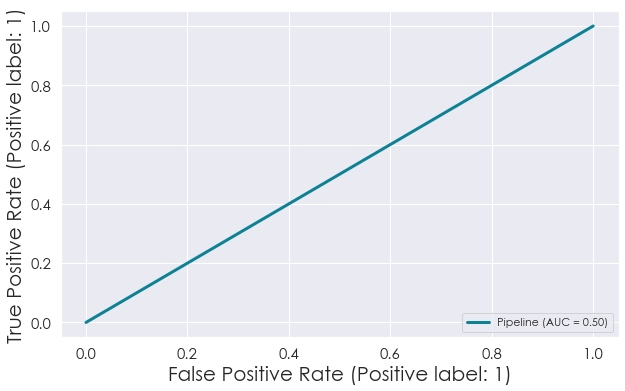

In [180]:
plot_roc_curve(baseline_pipe, Xval, yval)

Accuracy is high, but the recall of the model is low, hence an AUC of 0.5.
Best model has an AUC of 0.715

# ROC Curve and confusion matrix of the best model

In [181]:
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score

In [182]:
best_pipe.fit(Xval, yval)

[Pipeline] .............. (step 5 of 5) Processing LBMC, total=   0.7s


Pipeline(memory='D:/Dowloads_D/Data_OC/P7',
         steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', RobustScaler()),
                ('weight_strat',
                 RandomUnderSampler(random_state=42,
                                    sampling_strategy='majority')),
                ('feat_selec', SelectKBest(k=50)),
                ('LBMC',
                 LGBMClassifier(colsample_bytree=0.8, max_depth=7,
                                min_split_gain=0, n_estimators=40,
                                num_leaves=10, objective='binary',
                                random_state=42, reg_alpha=0.1, reg_lambda=0,
                                subsample=1))],
         verbose=True)

In [183]:
yval_pred = best_pipe.predict(Xval)
yval_pred_proba = best_pipe.predict_proba(Xval)

In [184]:
print("recall :", recall_score(yval, yval_pred))
print("accuracy :", accuracy_score(yval, yval_pred))
print("AUC :", roc_auc_score(yval, yval_pred_proba[:,1]))
print("custom :",cust_metric(yval, yval_pred))

recall : 0.6762296916260127
accuracy : 0.6782374620609914
AUC : 0.7393623238071105
custom : 0.12123139181962711


In [185]:
models_bs_check.append("Best model")
recalls_bs_check.append(recall_score(yval, yval_pred))
accuracy_bs_check.append(accuracy_score(yval, yval_pred))
auc_bs_check.append(roc_auc_score(yval, yval_pred_proba[:,1]))
fn_bs_check.append(1-recall_score(yval, yval_pred))
cust_metrics_bs_check.append(cust_metric(yval, yval_pred))

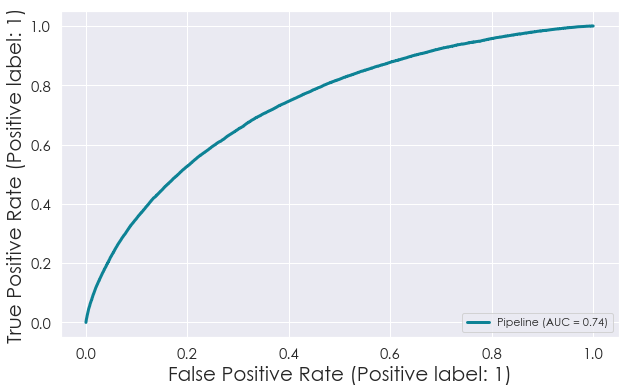

In [186]:
plot_roc_curve(best_pipe, Xval, yval)

In [187]:
cm_lgbm = confusion_matrix(yval, yval_pred, labels=[1, 0])
tn, fp, fn, tp = cm_lgbm.ravel()

In [188]:
cm_lgbm_df = pd.DataFrame(cm_lgbm
                          , index=[['Actual', 'Actual'], ['def', 'nodef']]
                          , columns=[['Predicted', 'Predicted'], ['def', 'nodef']])

In [189]:
cm_lgbm_df

Predicted        
                   def   nodef
Actual def       15109    7234
       nodef     81817  172600

In [190]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
# precision, recall, fscore, support = precision_recall_fscore_support(yval, yval_pred)
precision = precision_score(yval, yval_pred)
recall = recall_score(yval, yval_pred)
specificity = tn / (tn + fp)
fscore = f1_score(yval, yval_pred)

In [191]:
# cm_metrics = pd.Series([precision, recall, fscore, support], index = ['precision', 'recall', 'fscore', 'support'])
cm_metrics = pd.Series([precision, recall, specificity, fscore], index = ['precision', 'recall', 'specificity', 'fscore'])
cm_metrics

precision      0.155882
recall         0.676230
specificity    0.676230
fscore         0.253360
dtype: float64

## Optimize threshold to maximise False Negative (1-recall)

In [192]:
from sklearn.metrics import recall_score

In [193]:
def cust_predict_proba(pos_class_proba_array, thres=0.5):
    """This is a threshold function that convert an array of probabilities of belonging to class "1" into a array of labels 0 or 1 with respect to the threshold
    We will use this function to set up an optimal threshold that minimize false negative, unlike the default value of 0.5"""
    pos_class_proba_array = pd.Series(pos_class_proba_array)
    pos_class_proba_array = pos_class_proba_array.map(lambda x: 1 if x > thres else 0)
    return pos_class_proba_array.to_numpy()

In [194]:
scores = [] # i need to define the custom metric here that penalizes false negatives ut do not sacrifice accuracy too much
False_Negatives_rates = [] 
thresholds      = [0.95, 0.91, 0.86, 0.82, 0.77, 0.73, 0.68, 0.64, 0.59, 0.55, 0.5, 0.46, 0.41, 0.37, 0.32, 0.28, 0.23, 0.19, 0.14, 0.1]

for thr in thresholds:
    recall = recall_score(yval, cust_predict_proba(yval_pred_proba[:,1], thres=thr))
    false_negatives_rate = 1 - recall
    False_Negatives_rates.append(false_negatives_rate)
    scores.append(cust_metric(yval, cust_predict_proba(yval_pred_proba[:,1], thres=thr)))

Text(0.5, 0, 'default probability threshold')

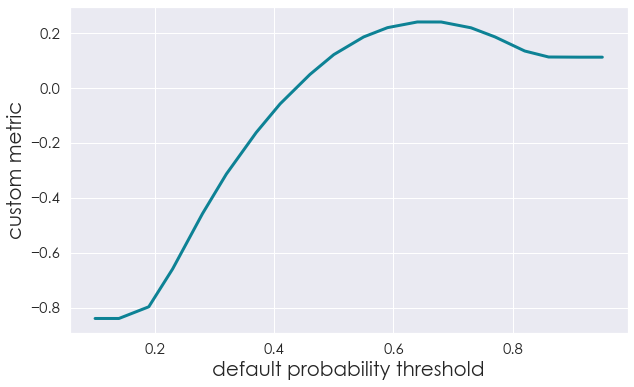

In [195]:
plt.plot(thresholds, scores)
plt.ylabel("custom metric")
plt.xlabel("default probability threshold")

In [196]:
cm_lgbm = confusion_matrix(yval, cust_predict_proba(yval_pred_proba[:,1], thres=0.65), labels=[1, 0])

In [197]:
cm_lgbm_df = pd.DataFrame(cm_lgbm
                          , index=[['Actual', 'Actual'], ['def', 'nodef']]
                          , columns=[['Predicted', 'Predicted'], ['def', 'nodef']])

In [198]:
cm_lgbm_df

Predicted        
                   def   nodef
Actual def        8693   13650
       nodef     30103  224314

In [199]:
# nous prédisons la classe avec le seuil optimal de 0.65
yval_pred_opti = cust_predict_proba(yval_pred_proba[:,1], thres=0.65)

In [200]:
print("recall :", recall_score(yval, yval_pred_opti))
print("accuracy :", accuracy_score(yval, yval_pred_opti))
print("AUC :", roc_auc_score(yval, yval_pred_proba[:,1]))
print("custom :",cust_metric(yval, yval_pred_opti))

recall : 0.38907040236315626
accuracy : 0.8419099580864287
AUC : 0.7393623238071105
custom : 0.23993351640410465


In [201]:
models_bs_check.append("Opti best model")
recalls_bs_check.append(recall_score(yval, yval_pred_opti))
accuracy_bs_check.append(accuracy_score(yval, yval_pred_opti))
auc_bs_check.append(roc_auc_score(yval, yval_pred_proba[:,1]))
fn_bs_check.append(1-recall_score(yval, yval_pred_opti))
cust_metrics_bs_check.append(cust_metric(yval, yval_pred_opti))

In [202]:
auc_bs_check

[0.5, 0.7393623238071105, 0.7393623238071105]

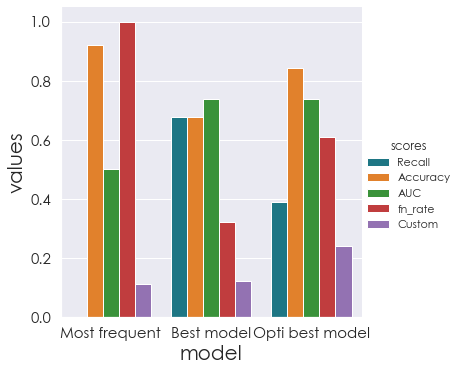

In [203]:
# in oder to plot the scores by model, we build a df and melt it to use train/test as an hue
df_model_bs_scores = pd.DataFrame()
df_model_bs_scores['model'] = models_bs_check
df_model_bs_scores['Recall'] = recalls_bs_check
df_model_bs_scores['Accuracy'] = accuracy_bs_check
df_model_bs_scores['AUC'] = auc_bs_check
df_model_bs_scores['fn_rate'] = fn_bs_check
df_model_bs_scores['Custom'] = cust_metrics_bs_check
df_model_bs_scores = pd.melt(df_model_bs_scores, id_vars='model', var_name='scores', value_name='values')
sns.catplot(data=df_model_bs_scores, x='model', y='values', hue='scores', kind='bar')
# plt.gca().set_ylim([0.6, 0.9])
# plt.gca().set_title('Comparison of mean train and test scores of RFC and LGBMC', fontsize=18)

# Test of best model

# Training of the best model

In [204]:
%%timeit
best_pipe.fit(train.iloc[:,:-1], train.iloc[:, -1])

[Pipeline] .............. (step 5 of 5) Processing LBMC, total=   0.5s
[Pipeline] .............. (step 5 of 5) Processing LBMC, total=   0.5s
[Pipeline] .............. (step 5 of 5) Processing LBMC, total=   0.4s
[Pipeline] .............. (step 5 of 5) Processing LBMC, total=   0.6s
[Pipeline] .............. (step 5 of 5) Processing LBMC, total=   0.5s
[Pipeline] .............. (step 5 of 5) Processing LBMC, total=   0.6s
[Pipeline] .............. (step 5 of 5) Processing LBMC, total=   0.4s
[Pipeline] .............. (step 5 of 5) Processing LBMC, total=   0.5s
6.89 s ± 335 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# Features importance best model

We are here analysing the features importance of the best model.

In [205]:
# getting indexes of the 50 columns selected by SelectKBest
selected_columns= best_pipe.named_steps["feat_selec"].get_support(indices=True)

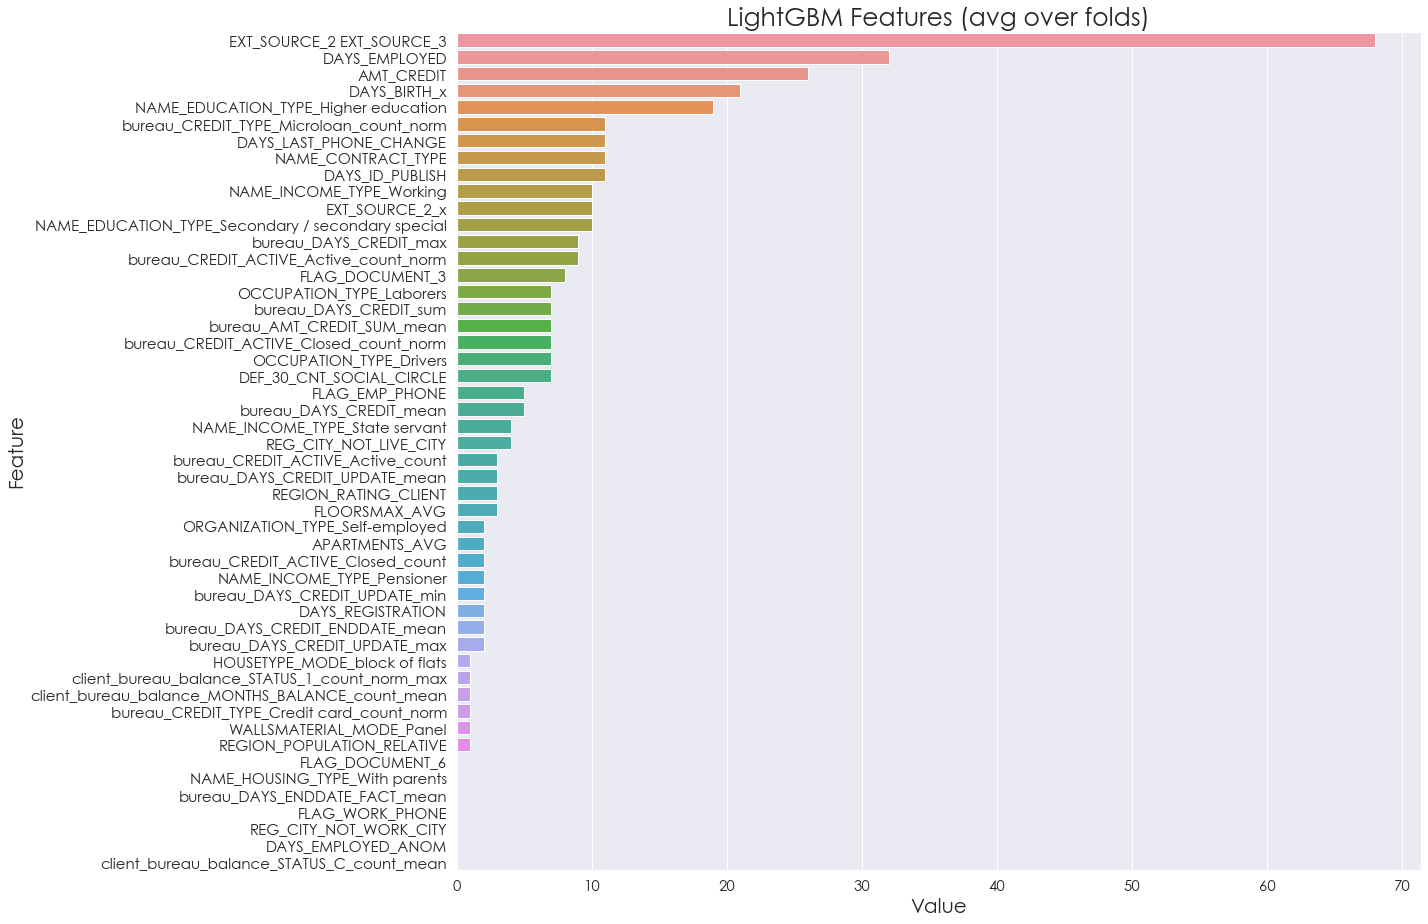

In [206]:
# collecting features importance of the selected columns in a Dataframe
feature_imp = pd.DataFrame(zip(best_pipe.named_steps["LBMC"].feature_importances_, train.iloc[:,selected_columns].columns), columns=['Value','Feature'])
plt.figure(figsize=(20, 13))
# and plotting it
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False).head(50))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()

# SHAP

In [207]:
import shap

### Xval preprocessed

In [208]:
# to use shap we need to compute the shap values of the preprocessed data
# and unfortunately shap.Explainer does not work directly with pipelines
Xval_prep = Xval.copy()
yval_prep = yval.copy()
for step in list(best_pipe.named_steps.keys())[:4]:
    print(step)
    # unlike other transformers, SMOTE apply fit_sample, to both X and y
    if step == 'weight_strat':
        Xval_prep, yval_prep = best_pipe.named_steps[step].fit_sample(Xval_prep, yval_prep)
    else:
        Xval_prep = best_pipe.named_steps[step].transform(Xval_prep)

imputer


ValueError: X has 311 features, but SimpleImputer is expecting 313 features as input.

In [ ]:
# then we need to store the preprocessed data as a df with the named features as colmuns
# storing the names of features after SelectKBest
feat_selec_cols = X.iloc[:,selected_columns].columns
# storing preprocessed Xval as a df with columns names
Xval_prep = pd.DataFrame(data=Xval_prep, columns=feat_selec_cols)

## Explainer and graphs

https://github.com/slundberg/shap/issues/1917

In [ ]:
model = best_pipe.named_steps['LBMC']
model.fit(Xval_prep, yval_prep)

In [ ]:
explainer = shap.TreeExplainer(model) # data is required if you're using interventional feature_perturbation
# or
# expainer = shap.Explainer(model, masker=X_) # masker required
# calculate shap with shap_values method

# if the below line is run in a different cell, I get an error of reshaping, no solution foundk
shapvs = explainer.shap_values(Xval_prep) # check should be default

In [ ]:
shapvs[0].shape

waterfall long : 2min

In [ ]:
# use the following function for waterfall: display contribution for one client
# tree explainer with LGBM returns the shap values of both class 0 and 1 : list of two arrays of shape (44686, 50)
# we are interested in explaining the contributions to default predictions so our shap values will be shapvs[1]
# more info here https://github.com/slundberg/shap/issues/837
shap.plots._waterfall.waterfall_legacy(explainer.expected_value[1], shapvs[1][0], features=Xval_prep.iloc[0].values, feature_names=Xval_prep.columns)

In [ ]:
shapvs[1][0, :].shape

In [ ]:
# visualize the first prediction's explanation with a force plot
shap.force_plot(explainer.expected_value[1], shapvs[1][0, :], features=Xval_prep.iloc[0,:], feature_names=feat_selec_cols)

In [ ]:
# summarize the effects of top features
shap.summary_plot(shapvs[1], Xval_prep.values, Xval_prep.columns, max_display=30)

Plus flag document 3 est faible (bleu), plus la proba de défaut est faible

# Pickling train data, explainer and model

In [ ]:
# exporting train data
train.to_csv("C:/Users/VP/Google Drive/Education/OC/working_directory/P7/train.csv") 
# exporting explainer and shap values
explainer_shapvs = [explainer, shapvs]
with open("C:/Users/VP/Google Drive/Education/OC/working_directory/P7/Credit_granting_CS_Streamlit/explainer_shapvs", 'wb') as fic:
    mon_pickler = pickle.Pickler(fic)
    mon_pickler.dump(explainer_shapvs)
# exporting final model
with open("C:/Users/VP/Google Drive/Education/OC/working_directory/P7/Credit_granting_CS_Streamlit/model", 'wb') as fic:
    mon_pickler = pickle.Pickler(fic)
    mon_pickler.dump(best_pipe)